# Finding the best station to give away flavored milk by the finish line of the NYC marathon


For this assessment, the goal is to identify the station that sees the biggest spike in entries by the New York Marathon finish line. In this fictional project, Nesquik is looking to promote its flavored milk varieties to runners after they run the marathon. 

The marathon is on the first Sunday of November every year. This comparison will compare data from the first sunday of November against the second and third Sundays of November, as well as the last 2 Sundays of October (2 sundays prior to race day, and 2 days after race day.) 

We will look at years 2016, 2017, 2018, 2019 and 2021. In 2020 the marathon did not occur. Data was pulled from the New York metra site for the months of October and November for the years listed above. This was compiled into the database file mta_data.db. Using SQLalchemy, we will connect Python to that database so we can use Pandas to modify the data.

One note of clarity- this assessment is the "cleaned up"/ "streamlined" assessment. The data and results did not change from the initial assessment; this is just a cleaned up version that streamlines the assessment. 

First import needed tools

In [64]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import date, timedelta
from sqlalchemy import create_engine

Create a an engine to use SQLAlchemy.

In [65]:
engine=create_engine("sqlite:///mta_data.db")
engine.table_names()

/var/folders/z4/gqr7pbzd1jx381lnrbtb0c4w0000gp/T/ipykernel_44458/150867708.py:2: SADeprecationWarning: The Engine.table_names() method is deprecated and will be removed in a future release.  Please refer to Inspector.get_table_names(). (deprecated since: 1.4)
  engine.table_names()


['mta_data']

The full mta_data.db file is 726.8MB, and would create a table of 8,660,638 rows. But by using a smarter SQL query, the file size will be significantly smaller. First identify the dates for race day each year, which is the first Sunday in November.

In [66]:
first_nov_suns=[]
years_used=[2016,2017,2018,2019,2021]
#create function to find first sunday of november based on example found here:
#https://www.w3resource.com/python-exercises/date-time-exercise/python-date-time-exercise-15.php
def find_first_nov_sun(year):
    nov_first=date(year, 11,1)
    nov_first_sun=nov_first+timedelta(6-nov_first.weekday())
    return nov_first_sun


for year in years_used:
    first_nov_suns.append(find_first_nov_sun(year))

first_nov_suns

[datetime.date(2016, 11, 6),
 datetime.date(2017, 11, 5),
 datetime.date(2018, 11, 4),
 datetime.date(2019, 11, 3),
 datetime.date(2021, 11, 7)]

Now find the other Sundays that will be used as comparison data (2 Sundays before race day, 2 sundays after race day. To do this, subtract 14 days from the dates in the racetime list, and then move forward 7 days 4 time each year/race date. 

In [67]:
sunday_data=[]

for sun in first_nov_suns:
    sun_data=sun-timedelta(days=14)
    count=5
    while count:
        sunday_data.append(str(sun_data.strftime('%m/%d/%Y')))
        sun_data+=timedelta(days=7)
        count-=1


print(sunday_data)


['10/23/2016', '10/30/2016', '11/06/2016', '11/13/2016', '11/20/2016', '10/22/2017', '10/29/2017', '11/05/2017', '11/12/2017', '11/19/2017', '10/21/2018', '10/28/2018', '11/04/2018', '11/11/2018', '11/18/2018', '10/20/2019', '10/27/2019', '11/03/2019', '11/10/2019', '11/17/2019', '10/24/2021', '10/31/2021', '11/07/2021', '11/14/2021', '11/21/2021']


Now create a string of all the dates to use with the SQLAlchemy program to import the data to Python

In [68]:
date_str='", "'.join(sunday_data)
sql_str='SELECT * FROM mta_data WHERE DATE in ("'+date_str+'");'
sql_str

'SELECT * FROM mta_data WHERE DATE in ("10/23/2016", "10/30/2016", "11/06/2016", "11/13/2016", "11/20/2016", "10/22/2017", "10/29/2017", "11/05/2017", "11/12/2017", "11/19/2017", "10/21/2018", "10/28/2018", "11/04/2018", "11/11/2018", "11/18/2018", "10/20/2019", "10/27/2019", "11/03/2019", "11/10/2019", "11/17/2019", "10/24/2021", "10/31/2021", "11/07/2021", "11/14/2021", "11/21/2021");'

Now pull the data into a Pandas Data Frame. Running the shape method we can see the resulting dataframe is only 726,322 rows which is significantly easier to manage. 

In [69]:
oct_nov_suns=pd.read_sql(sql_str, engine)
oct_nov_suns.shape

(726322, 11)

# Cleaning up the data

Now let's look at the data. 

In [70]:
oct_nov_suns.head()

,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESC,ENTRIES,EXITS
0,A002,R051,02-00-00,59 ST,NQR456W,BMT,11/21/2021,03:00:00,REGULAR,7665054,2633890
1,A002,R051,02-00-00,59 ST,NQR456W,BMT,11/21/2021,07:00:00,REGULAR,7665063,2633893
2,A002,R051,02-00-00,59 ST,NQR456W,BMT,11/21/2021,11:00:00,REGULAR,7665080,2633956
3,A002,R051,02-00-00,59 ST,NQR456W,BMT,11/21/2021,15:00:00,REGULAR,7665124,2634008
4,A002,R051,02-00-00,59 ST,NQR456W,BMT,11/21/2021,19:00:00,REGULAR,7665174,2634052


Stations are suppose to do readings every 4 hours on multiples of 4 (0, 4, 8, 12, 16, and 20). 

However during initial reviews of the data, it was identified that Daylight Savings Time affect stations differently. Some stations took readings at the multiples of 4 for half the year, but at (multiple of 4)-1 for the other half of the year (23, 3, 7, 11, 15, 19). Other stations took readings at the (multiples of 4)+1 and multiples of 4. Below are 2 stations that show this occurance. 

In [71]:
#This station had readings on (multiple of 4)+1
sta_81_ST_MUSEUM=oct_nov_suns[oct_nov_suns.STATION=='81 ST-MUSEUM']
sta_81_ST_MUSEUM.sample(5)


,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESC,ENTRIES,EXITS
158961,N045,R187,01-00-02,81 ST-MUSEUM,BC,IND,11/17/2019,20:00:00,REGULAR,4544600,1037062
507707,N044,R187,00-00-00,81 ST-MUSEUM,BC,IND,11/05/2017,01:00:00,REGULAR,6494790,1760911
249379,N044,R187,00-03-02,81 ST-MUSEUM,BC,IND,10/27/2019,01:00:00,REGULAR,4305993,6642857
158942,N044,R187,00-03-02,81 ST-MUSEUM,BC,IND,11/17/2019,16:00:00,REGULAR,4338815,6686763
188370,N044,R187,00-00-01,81 ST-MUSEUM,BC,IND,11/10/2019,16:00:00,REGULAR,17542252,3348496


In [72]:
#This stations had readings on (multiple of 4)-1
sta_57_ST_7=oct_nov_suns[oct_nov_suns.STATION=='57 ST-7 AV']
sta_57_ST_7.sample(5)

,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESC,ENTRIES,EXITS
472788,A011,R080,01-00-03,57 ST-7 AV,NQRW,BMT,11/12/2017,07:00:00,REGULAR,1662246652,1256772119
271934,A011,R080,01-03-01,57 ST-7 AV,NQRW,BMT,10/20/2019,04:00:00,REGULAR,16871289,18506055
357576,A011,R080,01-00-01,57 ST-7 AV,NQRW,BMT,11/04/2018,00:00:00,REGULAR,16763766,18255779
122286,A010,R080,00-00-06,57 ST-7 AV,NQRW,BMT,10/24/2021,16:00:00,REGULAR,20077449,5594468
531254,A011,R080,01-00-02,57 ST-7 AV,NQRW,BMT,10/29/2017,16:00:00,REGULAR,1561891641,1293001216


The good news is this analysis does not need data from all hours. 

The marathon starts at 8, and most people have an average time of 4.5 hours. There is a course time limit of 6 hours on the course. 6 hours after 8 am is 2pm. Even if it is assumed that not everyone starts at 6, and it takes up to an hour to start everyone, that means all runners need to be done by 3pm. This analysis therefore is concerned with the time window from 8am to 4pm.

In [73]:
#first fix the daylight savings time issue
oct_nov_suns.TIME=oct_nov_suns.TIME.str.replace('07:00:00', '08:00:00')
oct_nov_suns.TIME=oct_nov_suns.TIME.str.replace('09:00:00', '08:00:00')
oct_nov_suns.TIME=oct_nov_suns.TIME.str.replace('11:00:00', '12:00:00')
oct_nov_suns.TIME=oct_nov_suns.TIME.str.replace('13:00:00', '12:00:00')
oct_nov_suns.TIME=oct_nov_suns.TIME.str.replace('15:00:00', '16:00:00')
oct_nov_suns.TIME=oct_nov_suns.TIME.str.replace('17:00:00', '16:00:00')

In [74]:
df_4mask=(oct_nov_suns.TIME.isin(['08:00:00', '12:00:00', '16:00:00']))
oct_nov_suns=oct_nov_suns[df_4mask]
oct_nov_suns.head()

,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESC,ENTRIES,EXITS
1,A002,R051,02-00-00,59 ST,NQR456W,BMT,11/21/2021,08:00:00,REGULAR,7665063,2633893
2,A002,R051,02-00-00,59 ST,NQR456W,BMT,11/21/2021,12:00:00,REGULAR,7665080,2633956
3,A002,R051,02-00-00,59 ST,NQR456W,BMT,11/21/2021,16:00:00,REGULAR,7665124,2634008
7,A002,R051,02-00-01,59 ST,NQR456W,BMT,11/21/2021,08:00:00,REGULAR,6778027,1556610
8,A002,R051,02-00-01,59 ST,NQR456W,BMT,11/21/2021,12:00:00,REGULAR,6778038,1556650


The next step is more general cleaning of the dataset.

In [75]:
#Next check for non-null data points
oct_nov_suns.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 323909 entries, 1 to 726320
Data columns (total 11 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   C/A       323909 non-null  object
 1   UNIT      323909 non-null  object
 2   SCP       323909 non-null  object
 3   STATION   323909 non-null  object
 4   LINENAME  323909 non-null  object
 5   DIVISION  323909 non-null  object
 6   DATE      323909 non-null  object
 7   TIME      323909 non-null  object
 8   DESC      323909 non-null  object
 9   ENTRIES   323909 non-null  int64 
 10  EXITS     323909 non-null  int64 
dtypes: int64(2), object(9)
memory usage: 29.7+ MB


In [76]:
#this all looks good. 
#Next step is clean the string data 
oct_nov_suns.columns=[column.strip() for column in oct_nov_suns.columns]
oct_nov_suns['STATION']=oct_nov_suns['STATION'].str.strip()
oct_nov_suns['LINENAME']=oct_nov_suns['LINENAME'].str.strip()
oct_nov_suns['DIVISION']=oct_nov_suns['DIVISION'].str.strip()
oct_nov_suns['C/A']=oct_nov_suns['C/A'].str.strip()
oct_nov_suns['UNIT']=oct_nov_suns['UNIT'].str.strip()
oct_nov_suns['SCP']=oct_nov_suns['SCP'].str.strip()

In [77]:
#Looking at the DESC column:
oct_nov_suns.DESC.value_counts()

REGULAR       322255
RECOVR AUD      1654
Name: DESC, dtype: int64

This assessment is only concerned with Regular data, not audit. Filter out the audit data:

In [78]:
oct_nov_suns=oct_nov_suns[oct_nov_suns['DESC']=='REGULAR']
oct_nov_suns.DESC.value_counts()

REGULAR    322255
Name: DESC, dtype: int64

Finally, the last step is filter down to the stations that will be used in this assessment. 

Per the race website, the finish line will be in the southwest corner of Central Park. This assessment will look at stations close to that portion of the park. 

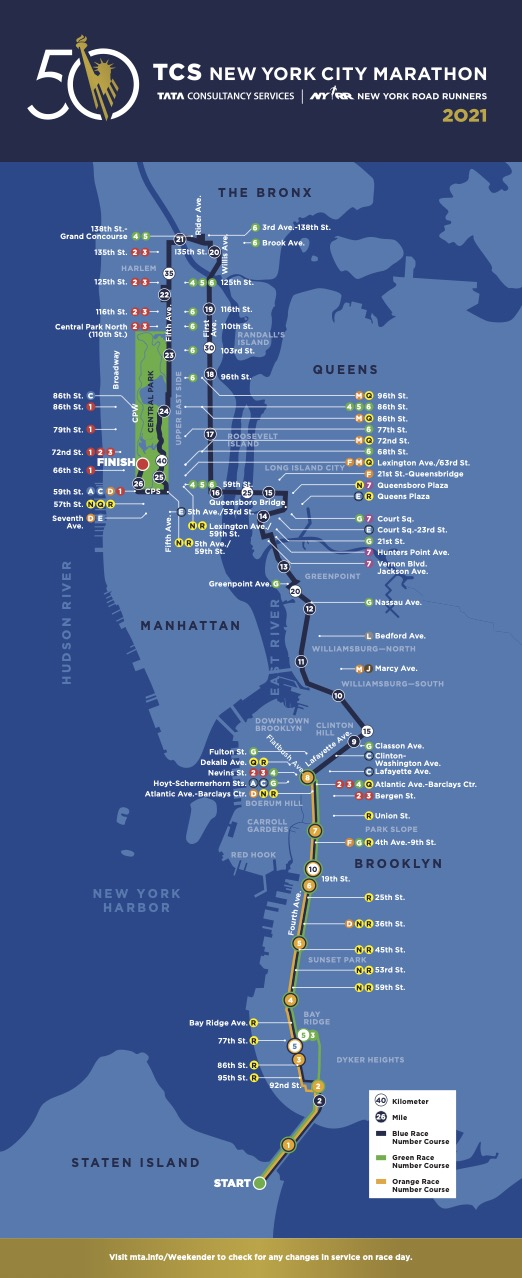

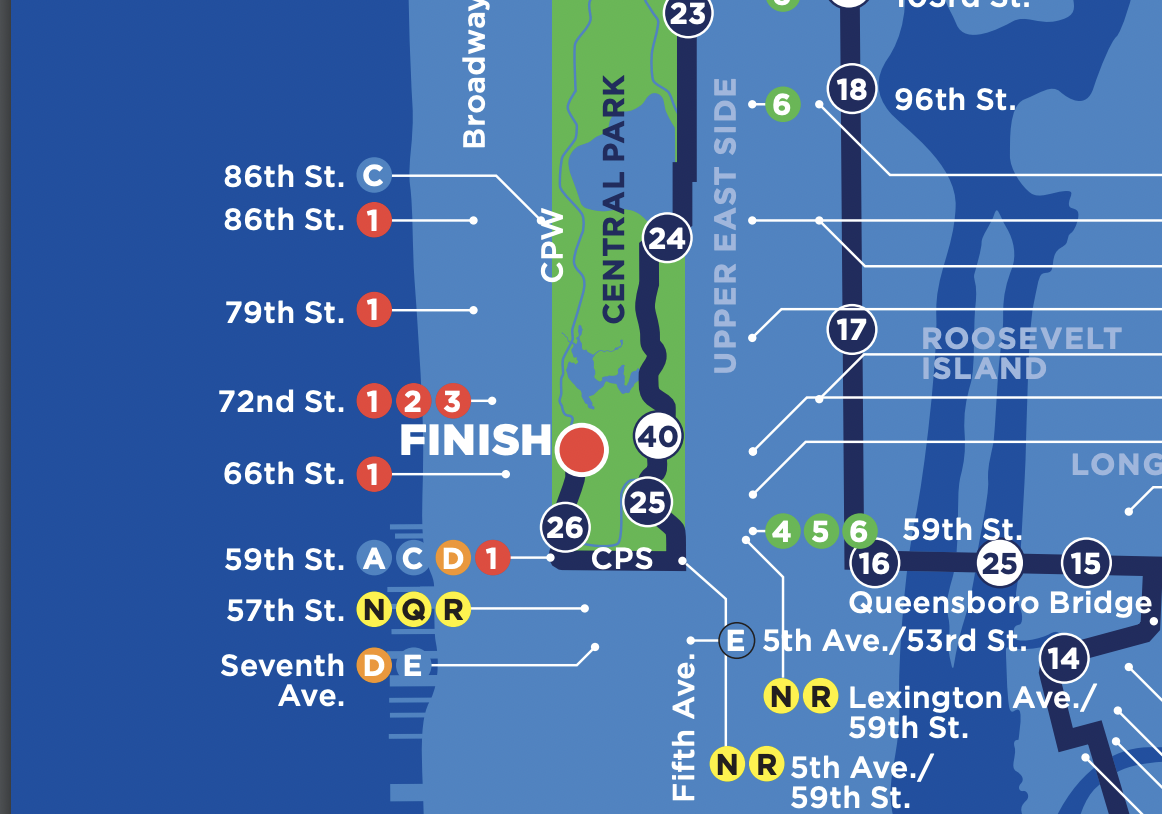

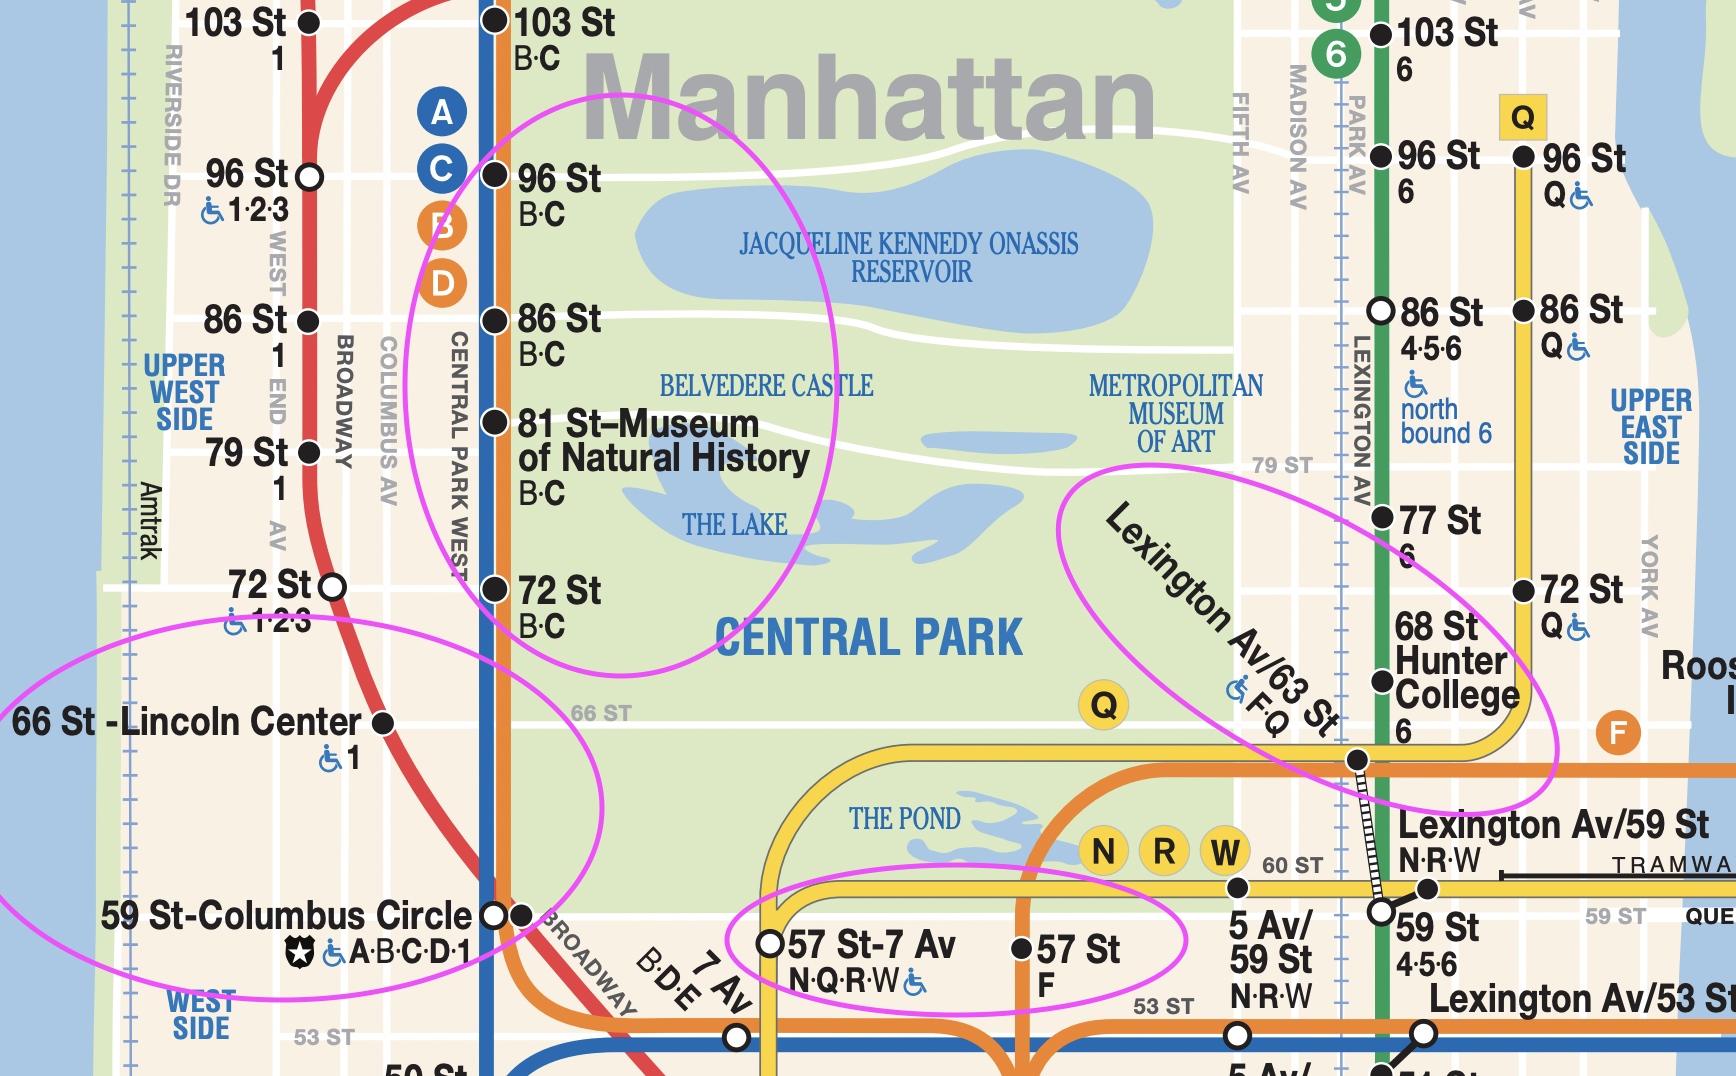

The stations in the pink circles in the above image will be used in this analysis. Additionally, the station at Zerega Ave will be added to the analysis as a comparison. This station is nowhere near the race so should not see a spike on race day. 

The other observation with the above image is there are many stations with similarly named stations. That will have to be addressed. 

The next step is generate the station list.

In [79]:
station_list=['86 ST', '81 ST - MUSEUM OF NATURAL HISTORY', '72 ST', '66 ST LINCOLN CENTER', 
              '59 ST COLUMBUS CIRCLE', '57 ST / 7 AVE', '57 ST', '5 AV/ 59 ST', 
              'LEXINGTON AVE/ 63 ST', '68 ST HUNTER COLLEGE', 'ZEREGA AV']

Using this list and the images above, to make sure the correct stations (among similarly named stations) are filtered, lines that run through that station are assessed.

In [80]:
for sta in station_list:
    print('\n')
    print(sta)
    print(oct_nov_suns[oct_nov_suns['STATION']==sta].LINENAME.value_counts())



86 ST
456    1688
1      1002
R       691
BC      617
N       210
Name: LINENAME, dtype: int64


81 ST - MUSEUM OF NATURAL HISTORY
Series([], Name: LINENAME, dtype: int64)


72 ST
123    1548
BC      465
Name: LINENAME, dtype: int64


66 ST LINCOLN CENTER
Series([], Name: LINENAME, dtype: int64)


59 ST COLUMBUS CIRCLE
Series([], Name: LINENAME, dtype: int64)


57 ST / 7 AVE
Series([], Name: LINENAME, dtype: int64)


57 ST
F    840
Name: LINENAME, dtype: int64


5 AV/ 59 ST
Series([], Name: LINENAME, dtype: int64)


LEXINGTON AVE/ 63 ST
Series([], Name: LINENAME, dtype: int64)


68 ST HUNTER COLLEGE
Series([], Name: LINENAME, dtype: int64)


ZEREGA AV
6    450
Name: LINENAME, dtype: int64


Many of the stations did not work. The next step is to create a mask to try to identify the station names using OR contain statements

In [81]:
df_sta_test_mask=((oct_nov_suns.STATION.str.contains('81')) |
                  (oct_nov_suns.STATION.str.contains('66')) |
                  (oct_nov_suns.STATION.str.contains('59')) |
                  (oct_nov_suns.STATION.str.contains('57')) |
                  (oct_nov_suns.STATION.str.contains('5'))  |
                  (oct_nov_suns.STATION.str.contains('59')) | #for 5 av/ 59th, listed both
                  (oct_nov_suns.STATION.str.contains('LEXINGTON')) | #for lexington/ 63 listed both
                  (oct_nov_suns.STATION.str.contains('63')) |
                  (oct_nov_suns.STATION.str.contains('68')) )

In [82]:
df_sta_test=oct_nov_suns[df_sta_test_mask]
#use this mask to find station options and line name options
df_sta_test.STATION.value_counts()

59 ST              3937
125 ST             3197
59 ST COLUMBUS     3057
47-50 STS ROCK     2685
50 ST              2670
LEXINGTON AV/53    2400
51 ST              1725
135 ST             1717
66 ST-LINCOLN      1700
LEXINGTON AV/63    1421
145 ST             1391
168 ST             1358
57 ST-7 AV         1224
175 ST             1200
63 DR-REGO PARK    1118
68ST-HUNTER CO     1036
5 AV/53 ST          945
57 ST               840
181 ST              810
81 ST-MUSEUM        749
5 AVE               746
75 AV               720
BAY RIDGE-95 ST     675
5 AV/59 ST          630
NORWOOD 205 ST      600
155 ST              600
157 ST              599
174-175 STS         540
163 ST-AMSTERDM     540
53 ST               540
25 ST               447
52 ST               432
BEACH 105 ST        374
MARBLE HILL-225     373
75 ST-ELDERTS       371
BEACH 25 ST         361
EAST 105 ST         300
45 ST               300
85 ST-FOREST PK     300
215 ST              294
BAY 50 ST           225
65 ST           

Comparing the above names to the prior outputs it seems most of the fixes to the station list were identified.  The exception is '5 av/59th st'. 
looking at google maps it looks like NRW lines run through that station. 
Using the train lines through that station:

In [83]:
df_sta_test[df_sta_test['STATION']=='5 AVE'].LINENAME.value_counts()

7BDFM    746
Name: LINENAME, dtype: int64

In [84]:
df_sta_test[df_sta_test['STATION']=='59 ST'].LINENAME.value_counts()

456NQRW    2270
NQR456W     833
NRW         675
456NQR       96
NQR456       36
NR           27
Name: LINENAME, dtype: int64

In [85]:
#NRW is an option, so 59 ST is the missing station. Updating the list:
station_list=['86 ST', '81 ST-MUSEUM', '72 ST', '66 ST-LINCOLN', 
              '59 ST COLUMBUS', '57 ST-7 AV', '57 ST', '59 ST', 
              'LEXINGTON AV/63', '68ST-HUNTER CO', 'ZEREGA AV']

In [86]:
for sta in station_list:
    print('\n')
    print(sta)
    print(oct_nov_suns[oct_nov_suns['STATION']==sta].LINENAME.value_counts())



86 ST
456    1688
1      1002
R       691
BC      617
N       210
Name: LINENAME, dtype: int64


81 ST-MUSEUM
BC    749
Name: LINENAME, dtype: int64


72 ST
123    1548
BC      465
Name: LINENAME, dtype: int64


66 ST-LINCOLN
1    1700
Name: LINENAME, dtype: int64


59 ST COLUMBUS
ABCD1    2021
1ABCD    1036
Name: LINENAME, dtype: int64


57 ST-7 AV
NQRW    1182
NQR       42
Name: LINENAME, dtype: int64


57 ST
F    840
Name: LINENAME, dtype: int64


59 ST
456NQRW    2270
NQR456W     833
NRW         675
456NQR       96
NQR456       36
NR           27
Name: LINENAME, dtype: int64


LEXINGTON AV/63
F    1421
Name: LINENAME, dtype: int64


68ST-HUNTER CO
6    1036
Name: LINENAME, dtype: int64


ZEREGA AV
6    450
Name: LINENAME, dtype: int64


It seems all stations were identified. Using this, create a new mask to filter to the 11 stations.

In [87]:
station_mask=(((oct_nov_suns.STATION=='86 ST') & (oct_nov_suns.LINENAME=='BC'))|
              (oct_nov_suns.STATION=='81 ST-MUSEUM')|
              ((oct_nov_suns.STATION=='72 ST') & (oct_nov_suns.LINENAME=='BC'))|
              (oct_nov_suns.STATION=='66 ST-LINCOLN')|
              (oct_nov_suns.STATION=='59 ST COLUMBUS')|
              (oct_nov_suns.STATION=='57 ST-7 AV')|
              (oct_nov_suns.STATION=='57 ST')|
              ((oct_nov_suns.STATION=='59 ST')& (oct_nov_suns.LINENAME=='NRW'))|
              (oct_nov_suns.STATION=='LEXINGTON AV/63')|
              (oct_nov_suns.STATION=='ZEREGA AV') |
              (oct_nov_suns.STATION=='68ST-HUNTER CO'))
oct_nov_suns=oct_nov_suns[station_mask]

The next step is to combine the C/A, Unit and SCP columns into a combined column, called TURN_ID.

In [88]:
oct_nov_suns['TURN_ID']=oct_nov_suns['C/A']+' '+oct_nov_suns['UNIT']+' '+oct_nov_suns['SCP']
oct_nov_suns.drop(columns=['C/A', 'SCP', 'UNIT', 'DIVISION', 'DESC', 'EXITS'], inplace=True)


Now fix the string data for the Stations in both the station list and the main database

In [89]:
station_list1=[s.replace(' ', '_') for s in station_list]
station_list2=[s.replace('/', '_') for s in station_list1]
station_listp=[s.replace('-', '_') for s in station_list2]
station_listp

['86_ST',
 '81_ST_MUSEUM',
 '72_ST',
 '66_ST_LINCOLN',
 '59_ST_COLUMBUS',
 '57_ST_7_AV',
 '57_ST',
 '59_ST',
 'LEXINGTON_AV_63',
 '68ST_HUNTER_CO',
 'ZEREGA_AV']

In [90]:
oct_nov_suns.STATION=oct_nov_suns.STATION.str.replace(' ', '_')
oct_nov_suns.STATION=oct_nov_suns.STATION.str.replace('/', '_')
oct_nov_suns.STATION=oct_nov_suns.STATION.str.replace('-', '_')
oct_nov_suns.sample(20)

,STATION,LINENAME,DATE,TIME,ENTRIES,TURN_ID
323240,68ST_HUNTER_CO,6,11/18/2018,16:00:00,1274326,R246 R177 00-00-01
307547,86_ST,BC,11/18/2018,12:00:00,11234,N043 R186 00-03-00
521468,66_ST_LINCOLN,1,11/05/2017,12:00:00,117440813,R160A R164 00-06-00
201429,59_ST_COLUMBUS,1ABCD,11/10/2019,12:00:00,427968,R158 R084 00-06-00
348399,59_ST_COLUMBUS,1ABCD,11/11/2018,08:00:00,3019636,R158 R084 00-00-02
593656,86_ST,BC,11/20/2016,12:00:00,990678951,N043 R186 00-06-00
307632,81_ST_MUSEUM,BC,11/18/2018,12:00:00,2174651,N045 R187 01-06-00
537581,81_ST_MUSEUM,BC,10/29/2017,08:00:00,3567349,N045 R187 01-00-02
459470,LEXINGTON_AV_63,F,11/19/2017,08:00:00,159558,N601 R319 00-00-04
108182,57_ST,F,10/31/2021,16:00:00,814533,N600 R302 00-05-03


Next create new columns that show the entries at 8a, 12p and 4p. This should create some NaN values, which will be replaced with zeros. This step is so when the data is grouped, the entries at 8a, 12p and 4p are kept for all stations. 

In [91]:
oct_nov_suns.loc[oct_nov_suns['TIME'].str.contains('08'), 'ENTRIES_8A']=oct_nov_suns['ENTRIES']
oct_nov_suns.loc[oct_nov_suns['TIME'].str.contains('12'), 'ENTRIES_12P']=oct_nov_suns['ENTRIES']
oct_nov_suns.loc[oct_nov_suns['TIME'].str.contains('16'), 'ENTRIES_4P']=oct_nov_suns['ENTRIES']
oct_nov_suns.head()

,STATION,LINENAME,DATE,TIME,ENTRIES,TURN_ID,ENTRIES_8A,ENTRIES_12P,ENTRIES_4P
157,57_ST_7_AV,NQRW,11/21/2021,08:00:00,5270903,A010 R080 00-00-00,5270903.0,NaN,NaN
158,57_ST_7_AV,NQRW,11/21/2021,12:00:00,5270962,A010 R080 00-00-00,NaN,5270962.0,NaN
159,57_ST_7_AV,NQRW,11/21/2021,16:00:00,5271088,A010 R080 00-00-00,NaN,NaN,5271088.0
163,57_ST_7_AV,NQRW,11/21/2021,08:00:00,15769396,A010 R080 00-00-01,15769396.0,NaN,NaN
164,57_ST_7_AV,NQRW,11/21/2021,12:00:00,15769431,A010 R080 00-00-01,NaN,15769431.0,NaN


In [92]:
#now get rid of the NaNs in those columns
oct_nov_suns.ENTRIES_8A.fillna(0, inplace=True)
oct_nov_suns.ENTRIES_12P.fillna(0, inplace=True)
oct_nov_suns.ENTRIES_4P.fillna(0, inplace=True)
oct_nov_suns.head()

,STATION,LINENAME,DATE,TIME,ENTRIES,TURN_ID,ENTRIES_8A,ENTRIES_12P,ENTRIES_4P
157,57_ST_7_AV,NQRW,11/21/2021,08:00:00,5270903,A010 R080 00-00-00,5270903.0,0.0,0.0
158,57_ST_7_AV,NQRW,11/21/2021,12:00:00,5270962,A010 R080 00-00-00,0.0,5270962.0,0.0
159,57_ST_7_AV,NQRW,11/21/2021,16:00:00,5271088,A010 R080 00-00-00,0.0,0.0,5271088.0
163,57_ST_7_AV,NQRW,11/21/2021,08:00:00,15769396,A010 R080 00-00-01,15769396.0,0.0,0.0
164,57_ST_7_AV,NQRW,11/21/2021,12:00:00,15769431,A010 R080 00-00-01,0.0,15769431.0,0.0


In [93]:
#Now group by station/ date, and turnstile

In [94]:
oct_nov_suns=oct_nov_suns.groupby([
    'STATION', 'TURN_ID', 'DATE']).agg(ENTRIES_8A=('ENTRIES_8A', 'max'), 
                                      ENTRIES_12P=('ENTRIES_12P', 'max'), 
                                      ENTRIES_4P=('ENTRIES_4P', 'max')).reset_index()


In [95]:
oct_nov_suns.head()

,STATION,TURN_ID,DATE,ENTRIES_8A,ENTRIES_12P,ENTRIES_4P
0,57_ST,N600 R302 00-00-00,10/20/2019,6295790.0,6295836.0,6295939.0
1,57_ST,N600 R302 00-00-00,10/22/2017,5973664.0,5973725.0,5973867.0
2,57_ST,N600 R302 00-00-00,10/23/2016,5706336.0,5706367.0,5706450.0
3,57_ST,N600 R302 00-00-00,10/24/2021,6449990.0,6450004.0,6450042.0
4,57_ST,N600 R302 00-00-00,10/27/2019,6302539.0,6302643.0,6302827.0


In [96]:
#Next, get the total daily entries and the total afternoon entries
oct_nov_suns['TOTAL_ENTRIES']=oct_nov_suns.ENTRIES_4P-oct_nov_suns.ENTRIES_8A
oct_nov_suns['AFTRN_ENTRIES']=oct_nov_suns.ENTRIES_4P-oct_nov_suns.ENTRIES_12P


In reviewing the data, it was identified that some turnstiles might have issues and not just increase in value. Some might count backwards, or some might reset. The first step is how many turnstiles have this issue.

In [97]:
(oct_nov_suns[oct_nov_suns["TOTAL_ENTRIES"] < 0]
    .groupby(['TURN_ID', "STATION", 'DATE'])
    .size())

TURN_ID             STATION        DATE      
A011 R080 01-00-00  57_ST_7_AV     10/21/2018    1
                                   10/22/2017    1
                                   10/23/2016    1
                                   10/28/2018    1
                                   10/29/2017    1
                                                ..
R159 R164 01-00-04  66_ST_LINCOLN  11/21/2021    1
R159 R164 01-05-00  66_ST_LINCOLN  11/21/2021    1
R159 R164 01-05-01  66_ST_LINCOLN  11/21/2021    1
R159 R164 01-06-00  66_ST_LINCOLN  11/21/2021    1
R159 R164 01-06-01  66_ST_LINCOLN  11/21/2021    1
Length: 84, dtype: int64

The next step is to correct this. This function was designed based off a function used on example data in the Metis Data bootcamp.

In [98]:
#modeled after the similar function in Metis course exercises.
def get_daily_counts(row, max_counter):
    counter = row["ENTRIES_4P"] - row["ENTRIES_8A"]
    if counter < 0:
        # Maybe counter is reversed?
        counter = -counter
    if counter > max_counter:
        # Maybe counter was reset to 0? 
        print(row["ENTRIES_4P"], row["ENTRIES_8A"])
        counter = min(row["ENTRIES_4P"], row["ENTRIES_8A"])
    if counter > max_counter:
        # Check it again to make sure we're not still giving a counter that's too big
        return 0
    return counter

counter_max=(60*60*8) #60 seconds * 60 minutes * 8 hours of data, aka 1 person per second. This is = 28800
counter_max=35000 # this was increased to be conservative.
# Just set it to zero as different counters have different cycle limits
# It'd probably be a good idea to use a number even significantly smaller than 1 million as the limit!
oct_nov_suns["TOTAL_ENTRIES"] = oct_nov_suns.apply(get_daily_counts, axis=1, max_counter=counter_max)

0.0 885854917.0
0.0 16770853.0
0.0 1562556414.0
0.0 1662993223.0
0.0 924673.0
0.0 2322066.0
0.0 50342853.0
0.0 14852945.0
1126314.0 0.0
373453.0 0.0
2182763.0 0.0
1216863.0 0.0
1606118.0 0.0
3920043.0 0.0
4423314.0 0.0
1923558.0 0.0
2293760.0 0.0
1192367.0 0.0
1036514321.0 0.0
1217099.0 0.0
81561.0 0.0
0.0 334004.0
0.0 3012360.0
0.0 6029536.0
0.0 8576459.0
0.0 71776.0
0.0 100663299.0
0.0 54053.0
0.0 2304435.0
134217729.0 0.0
24658955.0 0.0
13784494.0 0.0
194175.0 0.0
5109768.0 0.0
4267246.0 0.0
3857236.0 0.0
677869.0 0.0
5374149.0 0.0
3007111.0 0.0
14362866.0 0.0
15791318.0 0.0
7624313.0 0.0
2373820.0 0.0
20486042.0 0.0
0.0 991068212.0
0.0 634399.0


In [99]:
#recheck for negative stations
(oct_nov_suns[oct_nov_suns["TOTAL_ENTRIES"] < 0]
    .groupby(['TURN_ID', "STATION", 'DATE'])
    .size())

Series([], dtype: int64)

The next step is group by station and date to see the total entries per day and in the afternoon.

In [100]:
oct_nov_suns=oct_nov_suns.groupby([
    'STATION', 'DATE']).agg({'TOTAL_ENTRIES':'sum', 'AFTRN_ENTRIES':'sum'}).reset_index()


In [101]:
oct_nov_suns.head()

,STATION,DATE,TOTAL_ENTRIES,AFTRN_ENTRIES
0,57_ST,10/20/2019,5689.0,3790.0
1,57_ST,10/22/2017,3235.0,1430.0
2,57_ST,10/23/2016,1445.0,942.0
3,57_ST,10/24/2021,1372.0,992.0
4,57_ST,10/27/2019,5359.0,3690.0


# Data Analysis

Before the stations with the highest gains is identified, the next step is to make sure there is a spike on race days by grouping by date.

In [102]:
oct_nov_suns.DATE=pd.to_datetime(oct_nov_suns.DATE)

In [103]:
date_only=oct_nov_suns.groupby('DATE').agg({'TOTAL_ENTRIES':'sum', 'AFTRN_ENTRIES':'sum'}).reset_index()
date_only.head(5)

,DATE,TOTAL_ENTRIES,AFTRN_ENTRIES
0,2016-10-23,51173.0,32795.0
1,2016-10-30,44326.0,33941.0
2,2016-11-06,64019.0,45201.0
3,2016-11-13,47670.0,-602021.0
4,2016-11-20,44816.0,28947.0


In [104]:
by_year_dict={2016:[], 2017:[], 2018:[], 2019:[],2021:[]}

In [105]:
def entries_to_dict(row,colname, dic):
    yr=row.DATE.year
    cn=str(colname)
    dic[yr].append(row[cn])

In [106]:
date_only.apply(entries_to_dict, axis=1, colname='TOTAL_ENTRIES', dic=by_year_dict)
by_year_dict

{2016: [51173.0, 44326.0, 64019.0, 47670.0, 44816.0],
 2017: [50402.0, 51490.0, 56560.0, 43261.0, 44555.0],
 2018: [53018.0, 57843.0, 62467.0, 37947.0, 38070.0],
 2019: [63381.0, 55326.0, 71157.0, 48367.0, 50248.0],
 2021: [22951.0, 20961.0, 30713.0, 21861.0, 19700.0]}

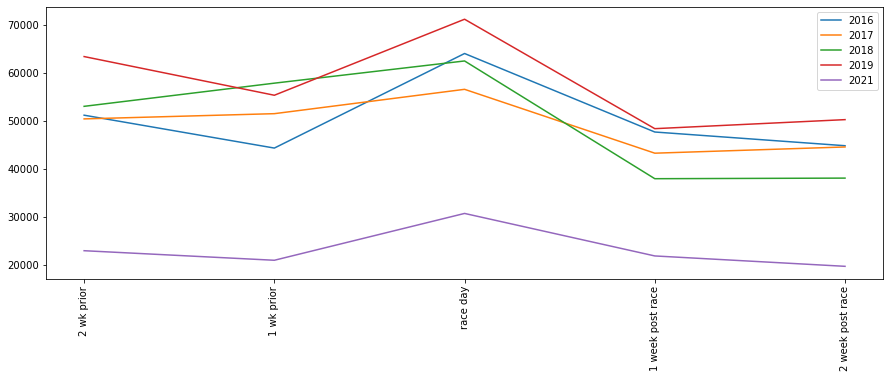

In [107]:
plt.figure(figsize=(15,5))
for value in by_year_dict.values():
    plt.plot(value)
xs=np.linspace(0,4,5)
week_des=['2 wk prior', '1 wk prior', 'race day', '1 week post race', '2 week post race']
plt.xticks(xs, week_des, rotation=90)
plt.legend(by_year_dict.keys())
plt.show()

The above chart shows a spike every year on race day. The next step is find the best station for the Nesquik popup. Now a dictionary needs to be created that utilizes station data. 

In [108]:
stationdict={}
for sta in station_listp:
    stationdict[sta]={2016:[], 2017:[], 2018:[], 2019:[],2021:[]}
print(stationdict)

{'86_ST': {2016: [], 2017: [], 2018: [], 2019: [], 2021: []}, '81_ST_MUSEUM': {2016: [], 2017: [], 2018: [], 2019: [], 2021: []}, '72_ST': {2016: [], 2017: [], 2018: [], 2019: [], 2021: []}, '66_ST_LINCOLN': {2016: [], 2017: [], 2018: [], 2019: [], 2021: []}, '59_ST_COLUMBUS': {2016: [], 2017: [], 2018: [], 2019: [], 2021: []}, '57_ST_7_AV': {2016: [], 2017: [], 2018: [], 2019: [], 2021: []}, '57_ST': {2016: [], 2017: [], 2018: [], 2019: [], 2021: []}, '59_ST': {2016: [], 2017: [], 2018: [], 2019: [], 2021: []}, 'LEXINGTON_AV_63': {2016: [], 2017: [], 2018: [], 2019: [], 2021: []}, '68ST_HUNTER_CO': {2016: [], 2017: [], 2018: [], 2019: [], 2021: []}, 'ZEREGA_AV': {2016: [], 2017: [], 2018: [], 2019: [], 2021: []}}


In [109]:
#REVISE ENTRIES TO DICT FUNCTION
def entries_to_dict2(row,colname, dic):
    yr=row.DATE.year
    cn=str(colname)
    dic[row.STATION][yr].append(row[cn])

In [110]:
oct_nov_suns.apply(entries_to_dict2, axis=1, colname='TOTAL_ENTRIES', dic=stationdict)
stationdict

{'86_ST': {2016: [2748.0, 2197.0, 3896.0, 2246.0, 1678.0],
  2017: [1828.0, 1707.0, 3384.0, 1482.0, 1944.0],
  2018: [1490.0, 3428.0, 732.0, 1184.0],
  2019: [3126.0, 2024.0, 4428.0, 2191.0, 1957.0],
  2021: [1038.0, 853.0, 1131.0, 1083.0, 0.0]},
 '81_ST_MUSEUM': {2016: [5516.0, 4872.0, 4705.0, 4065.0, 3287.0],
  2017: [4115.0, 7851.0, 4690.0, 3978.0, 3807.0],
  2018: [6567.0, 5673.0, 4298.0, 1801.0, 2840.0],
  2019: [7959.0, 8346.0, 5850.0, 4472.0, 3832.0],
  2021: [2231.0, 1830.0, 2551.0, 2483.0, 5.0]},
 '72_ST': {2016: [3366.0, 2590.0, 1839.0, 2196.0, 1497.0],
  2017: [2249.0, 2027.0, 1687.0, 2263.0, 2443.0],
  2018: [2355.0, 2960.0, 1898.0, 801.0, 1500.0],
  2019: [4376.0, 2226.0, 1960.0, 2332.0, 2076.0],
  2021: [1035.0, 957.0, 825.0, 1395.0, 0.0]},
 '66_ST_LINCOLN': {2016: [6044.0, 7753.0, 9888.0, 5132.0, 6124.0],
  2017: [3678.0, 4424.0, 6418.0, 3432.0, 3514.0],
  2018: [6182.0, 6683.0, 10169.0, 3803.0, 3778.0],
  2019: [4145.0, 6123.0, 10451.0, 5202.0, 5312.0],
  2021: [2198.0,

<Figure size 2160x6480 with 0 Axes>

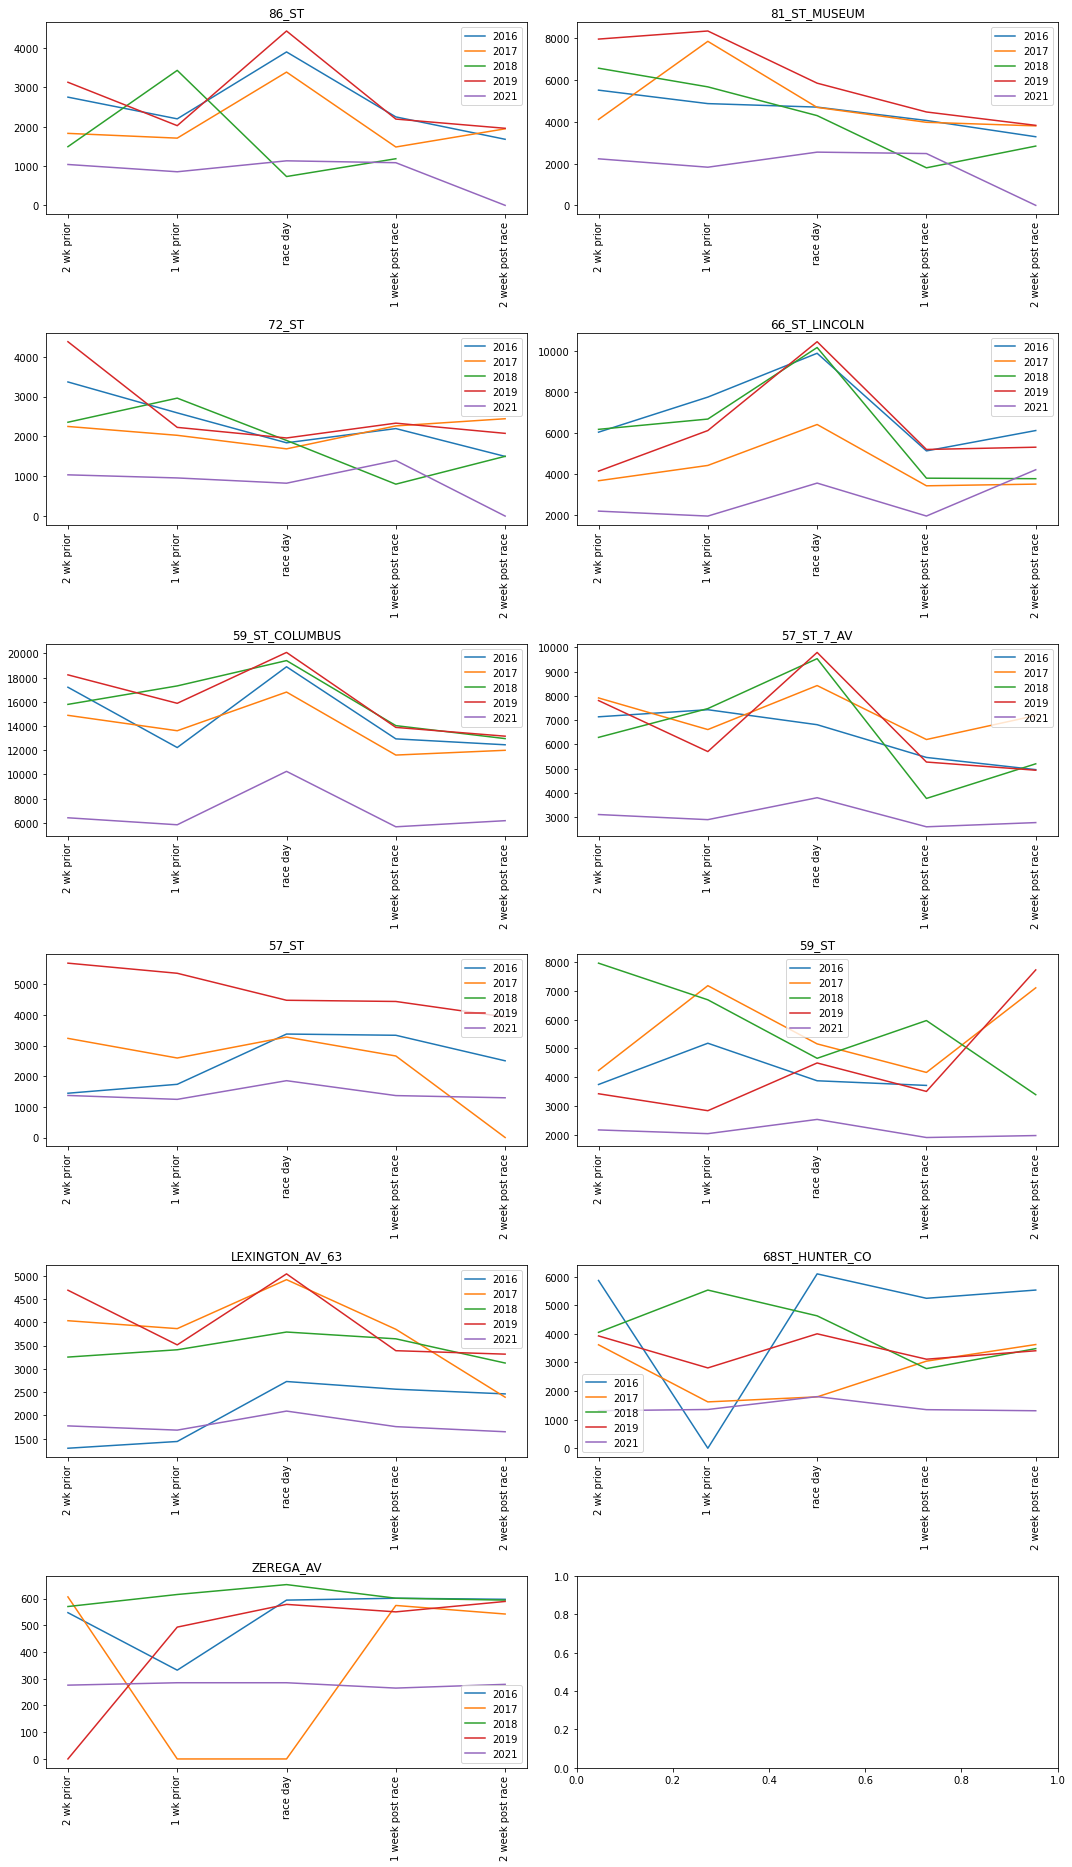

In [111]:
#Now the entries for each individual station are plotted.
plt.figure(figsize=(30,90))
fig, ax = plt.subplots(6, 2, figsize=(15,25))
index=1
for key in stationdict.keys():
    plt.subplot(6,2,index)
    plt.title(key)
    plt.tight_layout()
    plt.xticks(xs, week_des, rotation=90)
    for value in stationdict[key].values():
        plt.plot(value)
        plt.legend(stationdict[key].keys())
    index+=1
plt.savefig("stationplots.png")
plt.show()

Looking at the above charts, a few things stand out:

1) 86th st sees a clear spike on race day but is missing data from one day in 2018 which shifted that curve 2) The following stations are visibly affected by the race: 66_ST_LINCOLN, 59_ST_COLUMBUS, 57_ST_7_AV, LEXINGTON_AV_63 3) The marathon has minimal or no impact on these stations: 81_ST_MUSEUM,72_ST, 57_ST, 59_ST, 68ST_HUNTER_CO, and ZEREGA_AV (as expected- it was our control)

The next step is to update the dataframe to the stations that show a spike on raceday.

In [112]:
station_mask2=((oct_nov_suns.STATION=='86_ST')|
              (oct_nov_suns.STATION=='66_ST_LINCOLN')|
              (oct_nov_suns.STATION=='59_ST_COLUMBUS')|
              (oct_nov_suns.STATION=='57_ST_7_AV')|
              (oct_nov_suns.STATION=='LEXINGTON_AV_63'))

In [113]:
oct_nov_suns=oct_nov_suns[station_mask2]

# Final Assessment and Station Recommendation

Looking at the above charts for the stations selected, most times the race day is the peak point for that year. However, the number of people riding the train varies year to year (example- 2021 was a pandemic year, so all entries on all dates were lower on that year). This means that it does not make sense to take an average across all years. However it does make sense to average across the year to see which station gets the biggest spike in terms of actual people and percent increase. 

To do this, the first step is to add columns 1) identifying the year and 2) identifying if it is a race day or not

In [114]:
oct_nov_suns['YEAR']=oct_nov_suns.DATE.dt.year
oct_nov_suns.head()

,STATION,DATE,TOTAL_ENTRIES,AFTRN_ENTRIES,YEAR
20,57_ST_7_AV,2019-10-20,7809.0,4955.0,2019
21,57_ST_7_AV,2018-10-21,6293.0,4145.0,2018
22,57_ST_7_AV,2017-10-22,7917.0,4205.0,2017
23,57_ST_7_AV,2016-10-23,7140.0,3519.0,2016
24,57_ST_7_AV,2021-10-24,3117.0,1871.0,2021


In [115]:
#going back to early in the analysis, 
#race days are on first sunday in November which was previously defined:
first_nov_suns

[datetime.date(2016, 11, 6),
 datetime.date(2017, 11, 5),
 datetime.date(2018, 11, 4),
 datetime.date(2019, 11, 3),
 datetime.date(2021, 11, 7)]

In [116]:
oct_nov_suns['RACE_DAY']=oct_nov_suns.DATE.isin(first_nov_suns)
oct_nov_suns.head(20)

,STATION,DATE,TOTAL_ENTRIES,AFTRN_ENTRIES,YEAR,RACE_DAY
20,57_ST_7_AV,2019-10-20,7809.0,4.955000e+03,2019,False
21,57_ST_7_AV,2018-10-21,6293.0,4.145000e+03,2018,False
22,57_ST_7_AV,2017-10-22,7917.0,4.205000e+03,2017,False
23,57_ST_7_AV,2016-10-23,7140.0,3.519000e+03,2016,False
24,57_ST_7_AV,2021-10-24,3117.0,1.871000e+03,2021,False
25,57_ST_7_AV,2019-10-27,5709.0,3.425000e+03,2019,False
26,57_ST_7_AV,2018-10-28,7479.0,4.716000e+03,2018,False
27,57_ST_7_AV,2017-10-29,6615.0,3.319000e+03,2017,False
28,57_ST_7_AV,2016-10-30,7432.0,3.912000e+03,2016,False
29,57_ST_7_AV,2021-10-31,2906.0,1.955000e+03,2021,False


In [117]:
#finally add a column that duplicates TOTAL_ENTRIES on raceday
oct_nov_suns.loc[oct_nov_suns['RACE_DAY'], 'RACE_DAY_ENTRIES']=oct_nov_suns['TOTAL_ENTRIES']
oct_nov_suns.RACE_DAY_ENTRIES.fillna(0, inplace=True)
oct_nov_suns.head(20)

,STATION,DATE,TOTAL_ENTRIES,AFTRN_ENTRIES,YEAR,RACE_DAY,RACE_DAY_ENTRIES
20,57_ST_7_AV,2019-10-20,7809.0,4.955000e+03,2019,False,0.0
21,57_ST_7_AV,2018-10-21,6293.0,4.145000e+03,2018,False,0.0
22,57_ST_7_AV,2017-10-22,7917.0,4.205000e+03,2017,False,0.0
23,57_ST_7_AV,2016-10-23,7140.0,3.519000e+03,2016,False,0.0
24,57_ST_7_AV,2021-10-24,3117.0,1.871000e+03,2021,False,0.0
25,57_ST_7_AV,2019-10-27,5709.0,3.425000e+03,2019,False,0.0
26,57_ST_7_AV,2018-10-28,7479.0,4.716000e+03,2018,False,0.0
27,57_ST_7_AV,2017-10-29,6615.0,3.319000e+03,2017,False,0.0
28,57_ST_7_AV,2016-10-30,7432.0,3.912000e+03,2016,False,0.0
29,57_ST_7_AV,2021-10-31,2906.0,1.955000e+03,2021,False,0.0


The next step is deriving a new database STATION_GAINs that shows the increase in people on raceday compared to the rest of the year. This will be measured in actual people and percent increase. The Count column will also be added because at least one station is missing a day of data which would affect the average.

In [118]:
STATION_GAINS=oct_nov_suns.groupby(['STATION', 'YEAR']).agg(TOTAL_ENTRIES_SUM=('TOTAL_ENTRIES', 'sum'),
                                                           RACE_DAY_ENTRIES=('RACE_DAY_ENTRIES', 'max'),
                                                           COUNT=('YEAR', 'count')).reset_index()
STATION_GAINS.head(25)

,STATION,YEAR,TOTAL_ENTRIES_SUM,RACE_DAY_ENTRIES,COUNT
0,57_ST_7_AV,2016,31819.0,6815.0,5
1,57_ST_7_AV,2017,36354.0,8426.0,5
2,57_ST_7_AV,2018,32290.0,9534.0,5
3,57_ST_7_AV,2019,33527.0,9790.0,5
4,57_ST_7_AV,2021,15229.0,3809.0,5
5,59_ST_COLUMBUS,2016,73720.0,18899.0,5
6,59_ST_COLUMBUS,2017,68903.0,16808.0,5
7,59_ST_COLUMBUS,2018,79511.0,19409.0,5
8,59_ST_COLUMBUS,2019,81242.0,20083.0,5
9,59_ST_COLUMBUS,2021,34368.0,10255.0,5


The next step is find the average number of entries for each station for each year but excluding entries on raceday.

In [119]:
STATION_GAINS['COUNT']=STATION_GAINS['COUNT']-1
STATION_GAINS['NON_RACE_AVG']=(STATION_GAINS.TOTAL_ENTRIES_SUM-STATION_GAINS.RACE_DAY_ENTRIES)/(STATION_GAINS.COUNT)

In [120]:
STATION_GAINS.head()

,STATION,YEAR,TOTAL_ENTRIES_SUM,RACE_DAY_ENTRIES,COUNT,NON_RACE_AVG
0,57_ST_7_AV,2016,31819.0,6815.0,4,6251.00
1,57_ST_7_AV,2017,36354.0,8426.0,4,6982.00
2,57_ST_7_AV,2018,32290.0,9534.0,4,5689.00
3,57_ST_7_AV,2019,33527.0,9790.0,4,5934.25
4,57_ST_7_AV,2021,15229.0,3809.0,4,2855.00


Remove the total_entries_sum and Count columns, and add columns that show how many more people entered the station than the yearly average, and the percent increase.

In [121]:
STATION_GAINS.drop(columns=['TOTAL_ENTRIES_SUM', 'COUNT'], inplace=True)
STATION_GAINS['RACE_GAINS_PEOPLE']=STATION_GAINS.RACE_DAY_ENTRIES-STATION_GAINS.NON_RACE_AVG
STATION_GAINS['PERCENT_INCREASE']=STATION_GAINS.RACE_GAINS_PEOPLE/STATION_GAINS.NON_RACE_AVG*100

In [122]:
STATION_GAINS.head(25)

,STATION,YEAR,RACE_DAY_ENTRIES,NON_RACE_AVG,RACE_GAINS_PEOPLE,PERCENT_INCREASE
0,57_ST_7_AV,2016,6815.0,6251.000000,564.000000,9.022556
1,57_ST_7_AV,2017,8426.0,6982.000000,1444.000000,20.681753
2,57_ST_7_AV,2018,9534.0,5689.000000,3845.000000,67.586571
3,57_ST_7_AV,2019,9790.0,5934.250000,3855.750000,64.974512
4,57_ST_7_AV,2021,3809.0,2855.000000,954.000000,33.415061
5,59_ST_COLUMBUS,2016,18899.0,13705.250000,5193.750000,37.896062
6,59_ST_COLUMBUS,2017,16808.0,13023.750000,3784.250000,29.056531
7,59_ST_COLUMBUS,2018,19409.0,15025.500000,4383.500000,29.173738
8,59_ST_COLUMBUS,2019,20083.0,15289.750000,4793.250000,31.349433
9,59_ST_COLUMBUS,2021,10255.0,6028.250000,4226.750000,70.115705


Finally, it would be helpful to see these values as averages aggregated over each year. 

In [123]:
FINAL_RESULT=STATION_GAINS.groupby('STATION').agg({'RACE_GAINS_PEOPLE': 'mean', 'PERCENT_INCREASE': 'mean'}).reset_index()
FINAL_RESULT.head(5)

,STATION,RACE_GAINS_PEOPLE,PERCENT_INCREASE
0,57_ST_7_AV,2132.550000,39.136091
1,59_ST_COLUMBUS,4476.300000,39.518294
2,66_ST_LINCOLN,3515.150000,73.320998
3,86_ST,1621.233333,102.943335
4,LEXINGTON_AV_63,858.150000,29.953359


Plotting the number of entries above the yearly average for each station:

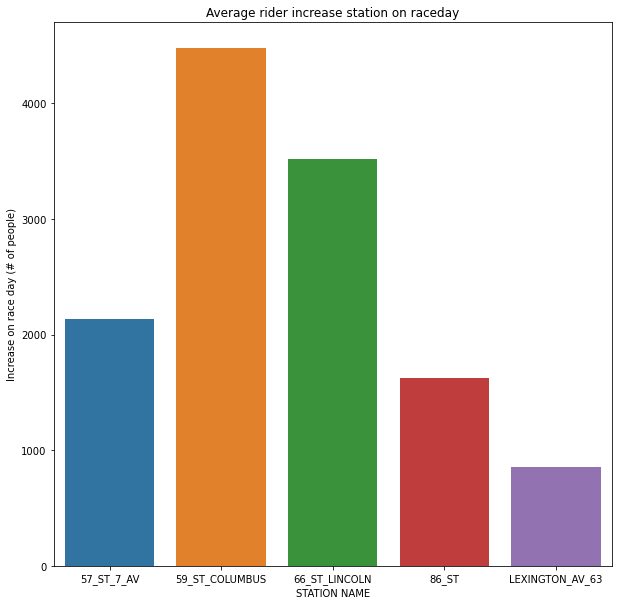

In [124]:
plt.figure(figsize=(10,10))
plt.savefig("Added entries by number of people.png")
ax=sns.barplot(x=FINAL_RESULT.STATION,
           y= FINAL_RESULT.RACE_GAINS_PEOPLE
           ).set(title='Average rider increase station on raceday', 
                 xlabel='STATION NAME', ylabel='Increase on race day (# of people)')


In [125]:
#Now plot this to show what percent increase that is.

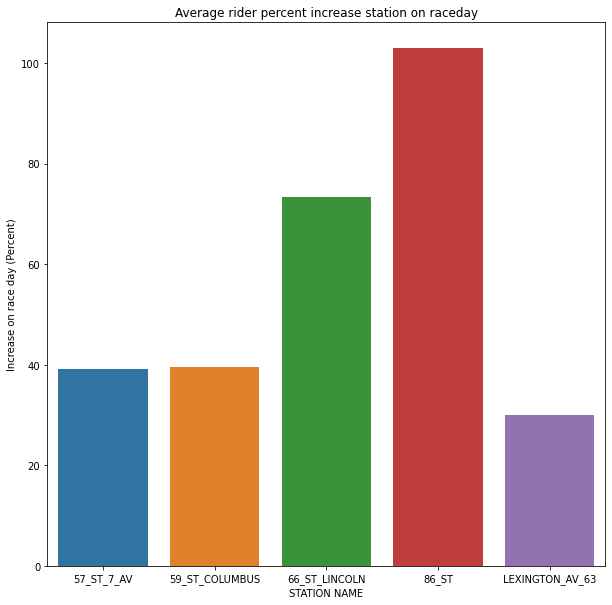

In [126]:
plt.figure(figsize=(10,10))
plt.savefig('Entries increases by percentage.png')
ax=sns.barplot(x=FINAL_RESULT.STATION,
           y= FINAL_RESULT.PERCENT_INCREASE
           ).set(title='Average rider percent increase station on raceday', 
                 xlabel='STATION NAME', ylabel='Increase on race day (Percent)')


# Conclusion

Based on the above charts, 66ST Lincoln has both a high average increase of entries, and a large perecentage increase. This makes it the best station for Nesquik's pop up station. 86ST had highest percent increase, and 59th st columbus had the most people increase but 66 ST Lincoln made the most sense because it is strong for both. 